These metrics are designed for binary classification, so you need to convert your multi-class labels into a format suitable for this type of analysis, that is multiple one-vs-all problems.

Data preview:
          Date  Latitude  Longitude  Sea_Surface_Temperature  HotSpots  \
0  01/01/1985     24.75    -81.625                    24.96       0.0   
1  01/02/1985     24.75    -81.625                    24.95       0.0   
2  01/03/1985     24.75    -81.625                    24.98       0.0   
3  01/04/1985     24.75    -81.625                    24.63       0.0   
4  01/05/1985     24.75    -81.625                    24.35       0.0   

   Degree_Heating_Weeks  Bleaching_Alert_Area  
0                   0.0                     0  
1                   0.0                     0  
2                   0.0                     0  
3                   0.0                     0  
4                   0.0                     0   

Accuracy: 0.9197

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3283
           1       0.75      0.77      0.76       715
           2       0.84      0.72      0.78       22

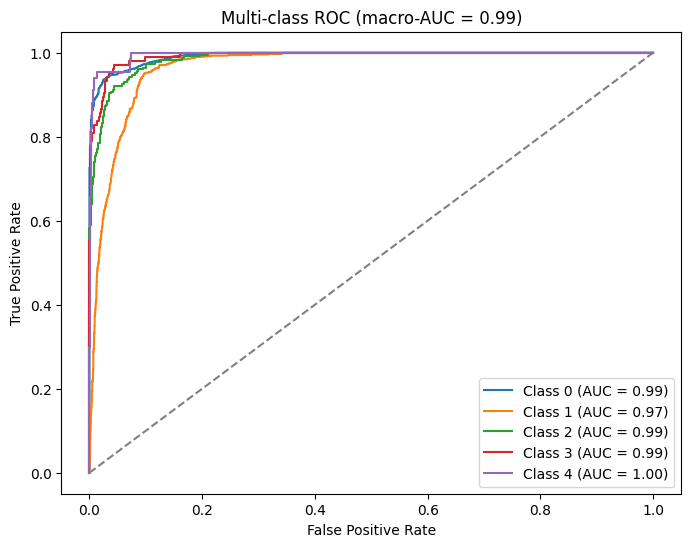

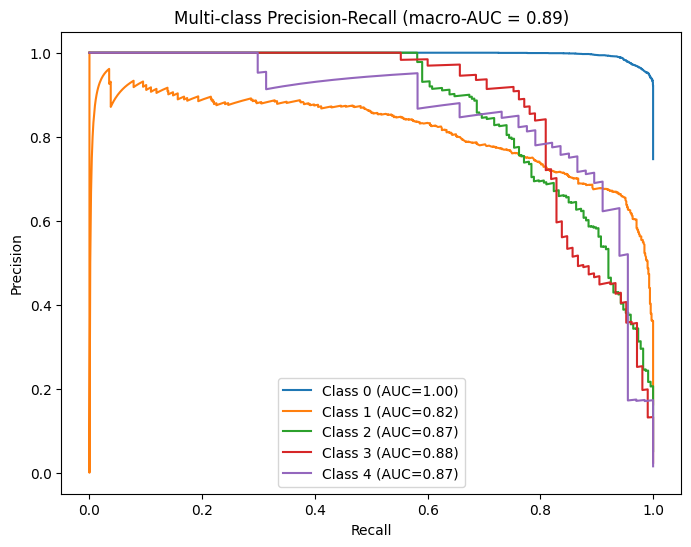

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, label_binarize
# StandardScaler module subtracts the mean and divides by the standard deviation.
# This ensures that all features have a similar range of values
#
# is label_binarize needed? since that is used to create a binary rep
# of word labels using one-hot encoding but we have all words anyway
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)
import matplotlib.pyplot as plt

# 1. LOAD THE DATA
file_path = "/content/drive/MyDrive/ML workshop/Florida_Keys.csv"  # Adjust if needed
data = pd.read_csv(file_path)

# Quick preview
print("Data preview:\n", data.head(), "\n")

required_columns = [
    'Date', 'Latitude', 'Longitude',
    'Sea_Surface_Temperature', 'HotSpots',
    'Degree_Heating_Weeks', 'Bleaching_Alert_Area'
]
for col in required_columns:
    if col not in data.columns:
        raise ValueError(f"Missing column: {col}")

# 2. SPLIT FEATURES (X) AND TARGET (y)
X = data.drop(columns=["Date", "Bleaching_Alert_Area"])
# Want X to be a table (df) of features
# "Bleaching_Alert_Area" removed because it is the target variable, not a feature!
# Your model needs to learn to predict this variable based on the other features,
# not by using the target itself!
y = data["Bleaching_Alert_Area"]

# 3. SCALE THE FEATURES
# 標準化，讓mean = 0 and STD = 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.3,
    random_state=42
)

# 5. TRAIN SVC WITH PROBABILITIES ENABLED
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# 6. PREDICT
y_pred = svm_model.predict(X_test)

# 7. EVALUATION: ACCURACY, CLASS REPORT, CONFUSION MATRIX
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


# ------------------------------------------------------------------------------
# 8. ROC CURVE & AUC FOR MULTI-CLASS (One-vs-Rest)
# ------------------------------------------------------------------------------
# Binarize the test labels for OvR metrics
classes = np.unique(y)  # e.g. [0,1,2,3,4]
y_test_bin = label_binarize(y_test, classes=classes)

# Get probability estimates (shape: [n_samples, n_classes])
y_score = svm_model.predict_proba(X_test)

# For storing fpr, tpr, roc_auc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(classes)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve/ROC AUC
# 1) Interpolate all ROC curves at distinct points
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average and compute AUC
mean_tpr /= n_classes
roc_auc_macro = auc(all_fpr, mean_tpr)

# Plot the one-vs-rest ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.title(f"Multi-class ROC (macro-AUC = {roc_auc_macro:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# ------------------------------------------------------------------------------
# 9. PRECISION-RECALL CURVE (One-vs-Rest)
# ------------------------------------------------------------------------------
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

# Macro-average for PR
all_recall = np.unique(np.concatenate([recall[i] for i in range(n_classes)]))
mean_precision = np.zeros_like(all_recall)
for i in range(n_classes):
    # We need to interpolate precision as a function of recall
    mean_precision += np.interp(all_recall, recall[i][::-1], precision[i][::-1])
mean_precision /= n_classes
pr_auc_macro = auc(all_recall, mean_precision)

# Plot the one-vs-rest Precision-Recall curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f"Class {classes[i]} (AUC={pr_auc[i]:.2f})")

plt.title(f"Multi-class Precision-Recall (macro-AUC = {pr_auc_macro:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()